In [1]:
import numpy as np
from numpy.random import default_rng
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import UnivariateSpline
from scipy.stats import gaussian_kde, sem
from matplotlib.patches import Circle
from sklearn.linear_model import LinearRegression, RidgeCV
from my_utils import *
from copy import deepcopy
from scipy.signal import savgol_filter

from pathlib import Path
import sys
import warnings

In [2]:
modelpath = Path('../model')
sys.path.append(str(modelpath))
import config.config as config

arg = config.ConfigPerturb()
arg.device = 'cpu'

In [3]:
# monkey data path
monkey_data_path = Path('../data/monkey_data')
# agents checkpoints path
progress_agents_path = Path('../data/agents')
# agents checkpoints performance path
training_curve_path = Path('../data/training_curve')
# figure path
figure_path = Path('../paper_figures/figure6')

# Load monkey data

In [4]:
data_path = monkey_data_path / 'Bruno'
bruno_normal_trajectory = pd.read_pickle(data_path / 'bruno_normal_trajectory_paper.pkl')
bruno_normal_trajectory_all = deepcopy_pd(bruno_normal_trajectory, is_df=True)
bruno_perturbation_trajectory = pd.read_pickle(data_path / 'bruno_perturbation_trajectory_paper.pkl')
bruno_perturbation_trajectory_all = deepcopy_pd(bruno_perturbation_trajectory, is_df=True)

data_path = monkey_data_path / 'Schro'
schro_normal_trajectory = pd.read_pickle(data_path / 'schro_normal_trajectory_paper.pkl')
schro_normal_trajectory_all = deepcopy_pd(schro_normal_trajectory, is_df=True)
schro_perturbation_trajectory = pd.read_pickle(data_path / 'schro_perturbation_trajectory_paper.pkl')
schro_perturbation_trajectory_all = deepcopy_pd(schro_perturbation_trajectory, is_df=True)

In [5]:
# Match similar perturbation trials between 2 monkeys.
EPISODE_SIZE = 1000
matching_variables = ['target_x', 'target_y', 'perturb_vpeak', 'perturb_wpeak', 'perturb_start_time_ori']

bruno_perturbation_trajectory, schro_perturbation_trajectory = match_similar_trials(
                                                                    bruno_perturbation_trajectory, 
                                                                    schro_perturbation_trajectory, 
                                                                    variables=matching_variables, is_scale=True,
                                                                    is_sort=True, EPISODE_SIZE=EPISODE_SIZE)

In [6]:
# Simulate no generalization cases
monkey_names = ['bruno', 'schro']

for monk_name in monkey_names:
    perturb_df = eval(f'{monk_name}_perturbation_trajectory')
    normal_df = match_similar_trials(eval(f'{monk_name}_normal_trajectory_all'), perturb_df, replace=True)
    locals()[f'{monk_name}_perturbation_trajectory'] = simulate_no_generalization(perturb_df, normal_df, 
                                                                                  subject='monkey')
    
    perturb_df2 = eval(f'{monk_name}_perturbation_trajectory_all')
    normal_df2 = match_similar_trials(eval(f'{monk_name}_normal_trajectory_all'), perturb_df2, replace=True)
    locals()[f'{monk_name}_perturbation_trajectory_all'] = simulate_no_generalization(perturb_df2, normal_df2, 
                                                                                      subject='monkey')

# Select agent checkpoints for analyses

In [7]:
def select_agents(progress_agents_path, agent_archs, MAX_TRAINING_T, task='perturbation'):
    perform_files = [[pd.read_csv(file)[(pd.read_csv(file).episode > 0) & (pd.read_csv(file).episode < MAX_TRAINING_T)] 
                      for file in (training_curve_path / task).glob(f'{agent_arch}_*.*')] 
                     for agent_arch in agent_archs]
    
    seeds = [[''.join(filter(str.isdigit, file.stem.split('_')[1]))
              for file in (training_curve_path / task).glob(f'{agent_arch}_*.*')] 
             for agent_arch in agent_archs]
    best_seeds = [seed[np.argmax([np.sum([file[file.task == task].reward_rate 
                                          for task in file.task.unique()], axis=0).max()
                                  for file in perform_file])] 
                  for perform_file, seed in zip(perform_files, seeds)]
    best_files_idx = [np.argmax([np.sum([file[file.task == task].reward_rate 
                                         for task in file.task.unique()], axis=0).max()
                                 for file in perform_file]) 
                      for perform_file in perform_files]
    
    best_paths = [progress_agents_path / agent_arch / 'gain' / f'seed{seed}'
                  for agent_arch, seed in zip(agent_archs, best_seeds)]
    
    best_files = [perform_file[file_idx] for perform_file, file_idx in zip(perform_files, best_files_idx)]
    best_episodes = [file.episode.unique()[np.sum([file[file.task == task].reward_rate 
                                                   for task in file.task.unique()], axis=0).argmax()] 
                     for file in best_files]

    best_agents = [list(best_path.glob(f'*-{best_episode}.*'))[0].stem.split('.')[0]
                   for best_path, best_episode in zip(best_paths, best_episodes)]
    
    return best_seeds, best_paths, best_agents, perform_files

In [8]:
Models = {'Holistic_Actor': 'Actor1', 'Holistic_Critic': 'Critic1',
          'Modular_Actor': 'Actor3', 'Modular_Critic': 'Critic5'}
for k, v in Models.items():
    exec(f'from {v} import {v[:-1]} as {k}')

agent_archs = [Models['Holistic_Actor'] + Models['Holistic_Critic'], 
               Models['Modular_Actor'] + Models['Holistic_Critic'],
               Models['Holistic_Actor'] + Models['Modular_Critic'],
               Models['Modular_Actor'] + Models['Modular_Critic']]

MAX_TRAINING_T = 1e4
task = 'perturbation'

In [9]:
best_seeds, best_paths, best_agents, perform_files = select_agents(progress_agents_path, 
                                                                   agent_archs, 
                                                                   MAX_TRAINING_T=MAX_TRAINING_T,
                                                                   task=task)

In [10]:
def select_agents_all(progress_agents_path, agent_archs, MAX_TRAINING_T, task='perturbation'):    
    seeds = [[''.join(filter(str.isdigit, file.stem.split('_')[1]))
              for file in (training_curve_path / task).glob(f'{agent_arch}_*.*')] 
             for agent_arch in agent_archs]
    
    agent_paths = []; agent_files = []
    for agent_arch, seeds_ in zip(agent_archs, seeds): # loop each agent
        agent_path = []; agent_file = []
        for seed in seeds_:
            perform_file_path = training_curve_path / task / f'{agent_arch}_seed{seed}.csv'
            perform_file = pd.read_csv(perform_file_path)
            perform_file = perform_file[(perform_file.episode > 0) & (perform_file.episode < MAX_TRAINING_T)]
            best_episode = perform_file.episode.unique()[np.sum([perform_file[perform_file.task == task].reward_rate 
                                      for task in perform_file.task.unique()], axis=0).argmax()]
            
            agent_path.append(progress_agents_path / agent_arch / 'gain' / f'seed{seed}')
            agent_file.append(list(agent_path[-1].glob(f'*-{best_episode}.*'))[0].stem.split('.')[0])
        agent_paths.append(agent_path); agent_files.append(agent_file)
    
    
    return agent_paths, agent_files

In [11]:
agent_paths, agent_files = select_agents_all(progress_agents_path, agent_archs, MAX_TRAINING_T, task='perturbation')

# Run agents

In [12]:
from Agent_RNN import *
from Environment import Env

In [13]:
def RNN_agent_simulation(arg, agent, target_positions, perturb_peaks, perturb_start_time_oris):
    reset_seeds(0)
    env = Env(arg)
    agent.bstep.obs_noise_range = arg.obs_noise_range

    pos_x = []; pos_y = []; head_dir = []; head_dir_end = []; pos_r = []
    pos_theta = []; pos_r_end = []; pos_theta_end = []; pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []; steps = []
    perturb_v = []; perturb_w = []; perturb_v_gauss = []; perturb_w_gauss = []
    state_ = []; action_ = []

    for target_position, perturb_peak, perturb_start_time_ori in zip(target_positions, perturb_peaks,
                                                                     perturb_start_time_oris):
        cross_start_threshold = False
        x = env.reset(target_position=target_position, perturbation_velocities=perturb_peak,
                      perturbation_start_t=perturb_start_time_ori)
        agent.bstep.reset(env.pro_gains)
        last_action = torch.zeros([1, 1, arg.ACTION_DIM])
        last_action_raw = last_action.clone()

        state = torch.cat([x[-arg.OBS_DIM:].view(1, 1, -1), last_action,
                           env.target_position.view(1, 1, -1)], dim=2).to(arg.device)

        hidden_in = None

        true_states = []
        actions = []
        states = []
        perturbations = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
            
            action, action_raw, hidden_out = agent.select_action(state, hidden_in, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep(next_x)
            next_state = torch.cat([next_ox.view(1, 1, -1), action,
                                    env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

            is_stop = env.is_stop(x, action)

            true_states.append(x)
            states.append(state)
            actions.append(action)
            perturbations.append(torch.stack((env.perturbation_vt, env.perturbation_wt)))
            
            last_action_raw = action_raw
            state = next_state
            x = next_x
            hidden_in = hidden_out

            if is_stop and cross_start_threshold:
                break

        # Trial end
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))
        
        state_.append(torch.cat(states))

        action_.append(torch.cat(actions))
        action_v_temp, action_w_temp = torch.chunk(torch.cat(actions).squeeze(1), 
                                                   action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())
        
        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        
        steps.append(np.arange(relative_r.size))
        
        perturb_v.append(torch.stack(perturbations)[:, 0].numpy() * arg.LINEAR_SCALE)
        perturb_w.append(np.rad2deg(torch.stack(perturbations)[:, 1].numpy()))
        perturb_v_gauss.append(env.gaussian_v_array.numpy() * arg.LINEAR_SCALE)
        perturb_w_gauss.append(np.rad2deg(env.gaussian_w_array.numpy()))
        
    agent.bstep.obs_noise_range = config.ConfigGain().obs_noise_range

    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, head_dir=head_dir, 
                                 head_dir_end=head_dir_end, pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end, steps=steps,
                                 perturb_v=perturb_v, perturb_w=perturb_w,
                                 perturb_vpeak=torch.stack(perturb_peaks)[:, 0].numpy() * arg.LINEAR_SCALE,
                                 perturb_wpeak=np.rad2deg(torch.stack(perturb_peaks)[:, 1].numpy()),
                                 perturb_start_time=torch.stack(perturb_start_time_oris).numpy(),
                                 perturb_v_gauss=perturb_v_gauss, perturb_w_gauss=perturb_w_gauss,
                                 gain_v=[env.process_gain_default[0].item() for _ in range(len(pos_x))],
                                 gain_w=[env.process_gain_default[1].item() for _ in range(len(pos_x))],
                                 state=state_, action=action_))

In [14]:
holistic_idx = 0
filename_holistic, arg.holistic_SEED_NUMBER = best_agents[holistic_idx], int(best_seeds[holistic_idx])
holistic_agent = Agent(arg, Holistic_Actor, Holistic_Critic)
holistic_agent.data_path = best_paths[holistic_idx]
holistic_agent.load(filename_holistic, load_memory=False, load_optimzer=False)

moho_idx = 1
filename_moho = best_agents[moho_idx]
moho_agent = Agent(arg, Modular_Actor, Holistic_Critic)
moho_agent.data_path = best_paths[moho_idx]
moho_agent.load(filename_moho, load_memory=False, load_optimzer=False)

homo_idx = 2
filename_homo = best_agents[homo_idx]
homo_agent = Agent(arg, Holistic_Actor, Modular_Critic)
homo_agent.data_path = best_paths[homo_idx]
homo_agent.load(filename_homo, load_memory=False, load_optimzer=False)

modular_idx = 3
filename_modular, arg.SEED_NUMBER = best_agents[modular_idx], int(best_seeds[modular_idx])
modular_agent = Agent(arg, Modular_Actor, Modular_Critic)
modular_agent.data_path = best_paths[modular_idx]
modular_agent.load(filename_modular, load_memory=False, load_optimzer=False)

In [15]:
target_positions = torch.tensor(bruno_perturbation_trajectory[['target_x', 'target_y']].values.T, 
                                dtype=torch.float32) / arg.LINEAR_SCALE
target_positions = torch.chunk(target_positions, len(bruno_perturbation_trajectory), dim=1)

perturb_peaks = torch.tensor(bruno_perturbation_trajectory[['perturb_vpeak', 'perturb_wpeak']].values, 
                             dtype=torch.float32)
perturb_peaks[:, 0] /= arg.LINEAR_SCALE
torch.deg2rad_(perturb_peaks[:, 1])
perturb_peaks = list(perturb_peaks)

perturb_start_time_oris = np.around(bruno_perturbation_trajectory['perturb_start_time_ori'].values / arg.DT)
perturb_start_time_oris = list(torch.tensor(perturb_start_time_oris, dtype=torch.int))

modular_perturbation_trajectory = RNN_agent_simulation(arg, modular_agent, target_positions, 
                                                        perturb_peaks, perturb_start_time_oris)
holistic_perturbation_trajectory = RNN_agent_simulation(arg, holistic_agent, target_positions, 
                                                         perturb_peaks, perturb_start_time_oris)
moho_perturbation_trajectory = RNN_agent_simulation(arg, moho_agent, target_positions, 
                                                     perturb_peaks, perturb_start_time_oris)
homo_perturbation_trajectory = RNN_agent_simulation(arg, homo_agent, target_positions, 
                                                     perturb_peaks, perturb_start_time_oris)

In [16]:
perturb_peaks_null = [torch.zeros(2) for _ in range(len(bruno_perturbation_trajectory))]

modular_normal_trajectory = RNN_agent_simulation(arg, modular_agent, target_positions, 
                                                  perturb_peaks_null, perturb_start_time_oris)
holistic_normal_trajectory = RNN_agent_simulation(arg, holistic_agent, target_positions, 
                                                   perturb_peaks_null, perturb_start_time_oris)
moho_normal_trajectory = RNN_agent_simulation(arg, moho_agent, target_positions, 
                                               perturb_peaks_null, perturb_start_time_oris)
homo_normal_trajectory = RNN_agent_simulation(arg, homo_agent, target_positions, 
                                               perturb_peaks_null, perturb_start_time_oris)

In [17]:
modular_perturbation_trajectory, holistic_perturbation_trajectory, \
moho_perturbation_trajectory, homo_perturbation_trajectory = map(simulate_no_generalization,
                                    [modular_perturbation_trajectory, holistic_perturbation_trajectory,
                                     moho_perturbation_trajectory, homo_perturbation_trajectory],
                                    [modular_normal_trajectory, holistic_normal_trajectory,
                                     moho_normal_trajectory, homo_normal_trajectory],
                                    ['agent'] * 4)

In [18]:
modular_agents = []
for agent_path, agent_file in zip(agent_paths[modular_idx], agent_files[modular_idx]):
    modular_agent_ = Agent(arg, Modular_Actor, Modular_Critic)
    modular_agent_.data_path = agent_path
    modular_agent_.load(agent_file, load_memory=False, load_optimzer=False)
    modular_agents.append(modular_agent_)
    
holistic_agents = []
for agent_path, agent_file in zip(agent_paths[holistic_idx], agent_files[holistic_idx]):
    holistic_agent_ = Agent(arg, Holistic_Actor, Holistic_Critic)
    holistic_agent_.data_path = agent_path
    holistic_agent_.load(agent_file, load_memory=False, load_optimzer=False)
    holistic_agents.append(holistic_agent_)
    
moho_agents = []
for agent_path, agent_file in zip(agent_paths[moho_idx], agent_files[moho_idx]):
    moho_agent_ = Agent(arg, Modular_Actor, Holistic_Critic)
    moho_agent_.data_path = agent_path
    moho_agent_.load(agent_file, load_memory=False, load_optimzer=False)
    moho_agents.append(moho_agent_)
    
homo_agents = []
for agent_path, agent_file in zip(agent_paths[homo_idx], agent_files[homo_idx]):
    homo_agent_ = Agent(arg, Holistic_Actor, Modular_Critic)
    homo_agent_.data_path = agent_path
    homo_agent_.load(agent_file, load_memory=False, load_optimzer=False)
    homo_agents.append(homo_agent_)

In [19]:
modular_perturbation_trajectories = list(map(RNN_agent_simulation, [arg] * len(modular_agents), modular_agents,
                                             [target_positions] * len(modular_agents), 
                                             [perturb_peaks] * len(modular_agents),
                                             [perturb_start_time_oris] * len(modular_agents)))
holistic_perturbation_trajectories = list(map(RNN_agent_simulation, [arg] * len(holistic_agents), holistic_agents,
                                              [target_positions] * len(holistic_agents), 
                                              [perturb_peaks] * len(holistic_agents),
                                              [perturb_start_time_oris] * len(holistic_agents)))
moho_perturbation_trajectories = list(map(RNN_agent_simulation, [arg] * len(moho_agents), moho_agents,
                                          [target_positions] * len(moho_agents), 
                                          [perturb_peaks] * len(moho_agents),
                                          [perturb_start_time_oris] * len(moho_agents)))
homo_perturbation_trajectories = list(map(RNN_agent_simulation, [arg] * len(homo_agents), homo_agents,
                                          [target_positions] * len(homo_agents), 
                                          [perturb_peaks] * len(homo_agents),
                                          [perturb_start_time_oris] * len(homo_agents)))

In [20]:
modular_normal_trajectories = list(map(RNN_agent_simulation, [arg] * len(modular_agents), modular_agents,
                                       [target_positions] * len(modular_agents),
                                       [perturb_peaks_null] * len(modular_agents), 
                                       [perturb_start_time_oris] * len(modular_agents)))
holistic_normal_trajectories = list(map(RNN_agent_simulation, [arg] * len(holistic_agents), holistic_agents,
                                        [target_positions] * len(holistic_agents), 
                                        [perturb_peaks_null] * len(holistic_agents),
                                        [perturb_start_time_oris] * len(holistic_agents)))
moho_normal_trajectories = list(map(RNN_agent_simulation, [arg] * len(moho_agents), moho_agents,
                                    [target_positions] * len(moho_agents), 
                                    [perturb_peaks_null] * len(moho_agents),
                                    [perturb_start_time_oris] * len(moho_agents)))
homo_normal_trajectories = list(map(RNN_agent_simulation, [arg] * len(homo_agents), homo_agents,
                                    [target_positions] * len(homo_agents), 
                                    [perturb_peaks_null] * len(homo_agents),
                                    [perturb_start_time_oris] * len(homo_agents)))

In [21]:
for (idx, mo_perturb_df), ho_perturb_df, moho_perturb_df, homo_perturb_df in zip(
    enumerate(modular_perturbation_trajectories), holistic_perturbation_trajectories, 
    moho_perturbation_trajectories, homo_perturbation_trajectories):
    modular_perturbation_trajectories[idx] = simulate_no_generalization(mo_perturb_df,
                                                                        modular_normal_trajectories[idx], 
                                                                        subject='agent')
    holistic_perturbation_trajectories[idx] = simulate_no_generalization(ho_perturb_df,
                                                                         holistic_normal_trajectories[idx], 
                                                                         subject='agent')
    moho_perturbation_trajectories[idx] = simulate_no_generalization(moho_perturb_df,
                                                                     moho_normal_trajectories[idx], 
                                                                     subject='agent')
    homo_perturbation_trajectories[idx] = simulate_no_generalization(homo_perturb_df,
                                                                     homo_normal_trajectories[idx], 
                                                                     subject='agent')

# Figures

In [22]:
locals().update(config_colors())
major_formatter = FuncFormatter(my_tickformatter)

param_ranges = param_prior_range()

fontsize = 7
lw = 1

## S6c-d

In [23]:
mean_reward_rate = [np.vstack([np.mean([file[file.task == task].reward_rate 
                                        for task in file.task.unique() if task != 'perturbation0'], axis=0)
                               for file in perform_file]).mean(axis=0) 
                    for perform_file in perform_files]
std_reward_rate = [sem(np.vstack([np.mean([file[file.task == task].reward_rate 
                                           for task in file.task.unique() if task != 'perturbation0'], axis=0) 
                                  for file in perform_file]), axis=0) 
                   for perform_file in perform_files]
mean_reward_null = [np.vstack([file[file.task == 'perturbation0'].reward_fraction for file in perform_file]).mean(axis=0) 
                    for perform_file in perform_files]

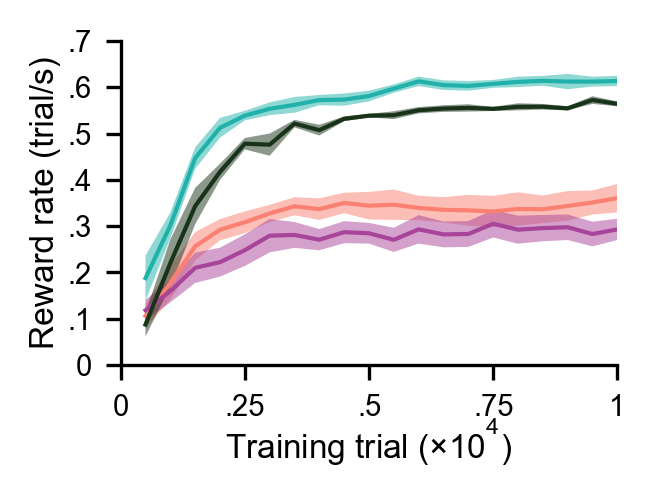

In [24]:
width = 2; height = 1.5

xaxis_scale = int(1e4)
yticks = np.around(np.linspace(0, 0.7, 8), 1)
xticks = np.linspace(0, MAX_TRAINING_T, 5)
xticklabels = [my_tickformatter(i, None) for i in xticks / xaxis_scale]
    
with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'Training trial ($\times$10$^4$)', fontsize=fontsize + 1)
    ax.set_ylabel('Reward rate (trial/s)', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.16)
    ax.yaxis.set_label_coords(-0.12, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    xdata = perform_files[0][0].episode.unique()
    for ymean, ystd, ynull, color, xshift in zip(mean_reward_rate, std_reward_rate, mean_reward_null,
                                                 [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c],
                                                 [0, 0, -400, 0, 400]):
        ax.plot(xdata, ymean, lw=lw, clip_on=True, c=color)
        ax.fill_between(xdata, ymean - ystd, ymean + ystd, edgecolor='None', facecolor=color, alpha=0.5)
    
    fig.tight_layout(pad=0.1, rect=(0, 0, 1, 1))

    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='sup_training_curve'), orientation='portrait', format='pdf', transparent=True)

In [25]:
mean_td_abs = [np.vstack([np.mean([file[file.task == task].TD_error_abs 
                                   for task in file.task.unique() if task != 'perturbation0'], axis=0)
                          for file in perform_file]).mean(axis=0) 
               for perform_file in perform_files]
std_td_abs = [sem(np.vstack([np.mean([file[file.task == task].TD_error_abs 
                                      for task in file.task.unique() if task != 'perturbation0'], axis=0) 
                             for file in perform_file]), axis=0) 
              for perform_file in perform_files]

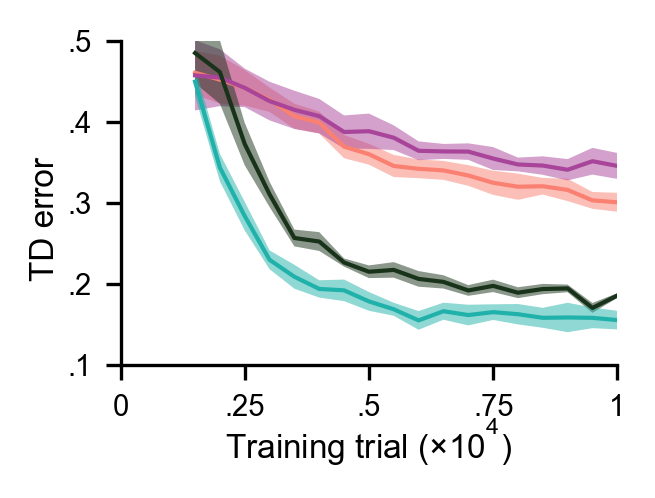

In [26]:
width = 2; height = 1.5

xaxis_scale = int(1e4)
yticks = np.around(np.arange(0.1, 0.51, 0.1), 1)
xticks = np.linspace(0, MAX_TRAINING_T, 5)
xticklabels = [my_tickformatter(i, None) for i in xticks / xaxis_scale]
    
with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'Training trial ($\times$10$^4$)', fontsize=fontsize + 1)
    ax.set_ylabel('TD error', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.16)
    ax.yaxis.set_label_coords(-0.12, 0.45)
    ax.yaxis.set_major_formatter(major_formatter)

    xdata = perform_files[0][0].episode.unique()
    for ymean, ystd, ynull, color in zip(mean_td_abs, std_td_abs, mean_reward_null,
                                         [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]):
        start_idx = np.where(ynull > 0.6)[0][0]
        ax.plot(xdata[start_idx:], ymean[start_idx:], lw=lw, clip_on=True, c=color)
        ax.fill_between(xdata[start_idx:], (ymean - ystd)[start_idx:], (ymean + ystd)[start_idx:],
                        edgecolor='None', facecolor=color, alpha=0.5)
    
    fig.tight_layout(pad=0.1, rect=(0, 0, 1, 1))

    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='sup_td_error'), orientation='portrait', format='pdf', transparent=True)

## 6b

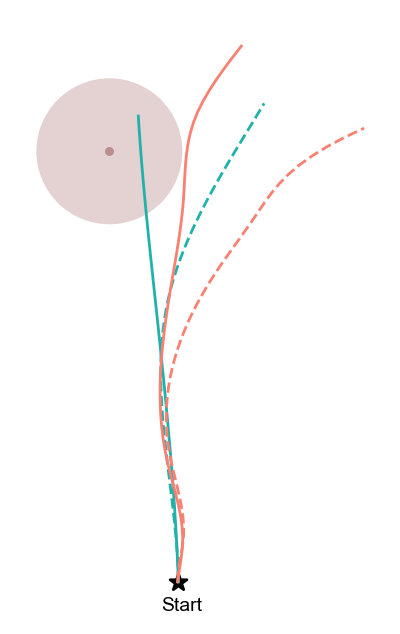

In [27]:
p_idx = 619
width = 3
height = 3
title_pad = 4

dfs = [modular_perturbation_trajectories[6], holistic_perturbation_trajectories[7]]
modular_trial, holistic_trial = [df.iloc[p_idx] for df in dfs]

with initiate_plot(width, height, 200) as fig, warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])
    
    # modular agent
    mx = modular_trial.pos_x; my = modular_trial.pos_y; mf = UnivariateSpline(my, mx)
    my_new = np.linspace(my[0], my[-1], endpoint=True)
    ax.plot(mf(my_new), my_new, lw=lw, c=modular_c)
    mx_ = modular_trial.sim_pos_x; my_ = modular_trial.sim_pos_y; mf_ = UnivariateSpline(my_, mx_)
    my_new_ = np.linspace(my_[0], my_[-1], endpoint=True)
    ax.plot(mf_(my_new_), my_new_, lw=lw, c=modular_c, ls='--')
    
    # holistic agent
    hx = holistic_trial.pos_x; hy = holistic_trial.pos_y; hf = UnivariateSpline(hy, hx)
    hy_new = np.linspace(hy[0], hy[-1], endpoint=True)
    ax.plot(hf(hy_new), hy_new, lw=lw, c=holistic_c)
    hx_ = holistic_trial.sim_pos_x; hy_ = holistic_trial.sim_pos_y; hf_ = UnivariateSpline(hy_, hx_)
    hy_new_ = np.linspace(hy_[0], hy_[-1], endpoint=True)
    ax.plot(hf_(hy_new_), hy_new_, lw=lw, c=holistic_c, ls='--')
    
    ax.plot([], [], lw=lw, c='k', label='Data')
    ax.plot([], [], lw=lw, c='k', ls='--', label='No generalization')
    
    # target position
    target_x = modular_trial.target_x; target_y = modular_trial.target_y
    cir1 = Circle(xy=[target_x, target_y], 
                  radius=arg.goal_radius_range[0] * arg.LINEAR_SCALE, 
                  alpha=0.4, color=reward_c, lw=0)
    ax.add_patch(cir1)
    ax.scatter(target_x, target_y, c=reward_c, s=5)
    
    # plot initial position
    ax.scatter(0, 0, c='k', s=40, marker='*')
    ax.text(-15, -25, s='Start', fontsize=fontsize)
    
    fig.tight_layout(pad=0.1, rect=[0.05, 0, 1.05, 1])
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #            name='trial_example'), orientation='portrait', format='pdf', transparent=True)

## 6a

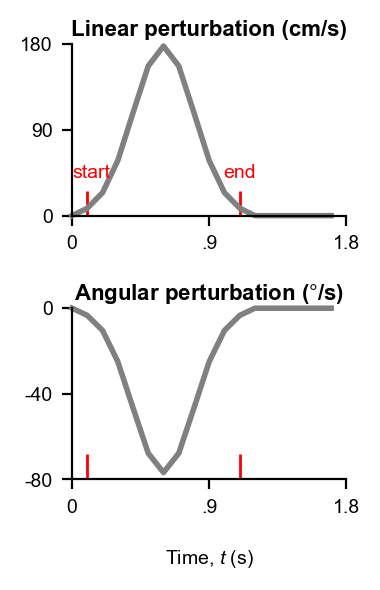

In [28]:
p_idx = 619
width = 1.7
height = 2.8
title_pad = 3

dfs = [modular_perturbation_trajectories[6], holistic_perturbation_trajectories[7]]
modular_trial, holistic_trial = [df.iloc[p_idx] for df in dfs]

with initiate_plot(width, height, 200) as fig, warnings.catch_warnings():
    warnings.simplefilter('ignore')
    axins = fig.add_subplot(211)
    axins.set_title('Linear perturbation (cm/s)', fontsize=fontsize + 1, pad=title_pad, fontweight='bold')
    axins.set_xticks([0, 0.9, 1.8])
    axins.set_xticks([0.1, 1.1], minor=True)
    axins.tick_params(axis='x', which='minor', colors='red', length=9, direction='in', width=1)
    axins.set_yticks(np.linspace(0, int(modular_trial.perturb_vpeak) + 2, 3).astype(int))
    axins.set_xticklabels(axins.get_xticks(), fontsize=fontsize)
    axins.set_yticklabels(np.linspace(0, int(modular_trial.perturb_vpeak) + 2, 3).astype(int), 
                          fontsize=fontsize)
    axins.set_xlabel('', fontsize=fontsize)
    axins.set_ylabel('', fontsize=fontsize)
    axins.spines['top'].set_visible(False)
    axins.spines['right'].set_visible(False)
    axins.set_xlim(axins.get_xticks()[[0, -1]]); axins.set_ylim(np.sort(axins.get_yticks()[[0, -1]]))
    axins.xaxis.set_major_formatter(major_formatter)

    axins.plot(np.arange(modular_trial.perturb_v.size) * arg.DT, modular_trial.perturb_v, 
               c='gray', lw=lw * 2, clip_on=False)
    axins.text(0, 40, 'start', fontsize=fontsize, c='r')
    axins.text(0.99, 40, 'end', fontsize=fontsize, c='r')
    
    axinst = fig.add_subplot(212)
    axinst.set_title('Angular perturbation ($\degree$/s)', fontsize=fontsize + 1, pad=title_pad, fontweight='bold')
    axinst.set_xticks([0, 0.9, 1.8])
    axinst.set_xticks([0.1, 1.1], minor=True)
    axinst.tick_params(axis='x', which='minor', colors='red', length=9, direction='in', width=1)
    axinst.set_yticks(np.linspace(0, -80, 3).astype(int))
    axinst.set_xticklabels(axinst.get_xticks(), fontsize=fontsize)
    axinst.set_yticklabels(np.linspace(0, -80, 3).astype(int), fontsize=fontsize)
    axinst.set_xlabel('Time, $t$ (s)', fontsize=fontsize)
    axinst.set_ylabel('', fontsize=fontsize)
    axinst.spines['top'].set_visible(False)
    axinst.spines['right'].set_visible(False)
    axinst.xaxis.set_label_coords(0.5, -0.4)
    axinst.set_xlim(axins.get_xticks()[[0, -1]]); axinst.set_ylim(np.sort(axinst.get_yticks()[[0, -1]]))
    axinst.xaxis.set_major_formatter(major_formatter)

    axinst.plot(np.arange(modular_trial.perturb_w.size) * arg.DT, modular_trial.perturb_w, 
                c='gray', lw=lw * 2, clip_on=False)
    
    fig.tight_layout(pad=0, h_pad=1, rect=[0, 0, 1, 1])
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #            name='perturbation_example'), orientation='portrait', format='pdf', transparent=True)

## 6c

In [29]:
subject_names = ['bruno', 'schro']
xdata = [np.linalg.norm(eval(f'{arg2}_perturbation_trajectory')[['perturb_vpeak', 'perturb_wpeak']], axis=1)
         for arg1, arg2 in cartesian_prod(['sim_', ''], subject_names)]
ydata_m = [eval(f'{arg2}_perturbation_trajectory.{arg1}relative_radius_end').values
           for arg1, arg2 in cartesian_prod(['sim_', ''], subject_names)]

In [30]:
smoothing_window = 100
x_sorted_idx = [np.argsort(data) for data in xdata]
xdata_sorted = [data[idx] for idx, data in zip(x_sorted_idx, xdata)]
ydata_sorted = [data[idx] for idx, data in zip(x_sorted_idx, ydata_m)]
ydata_mean = [pd.Series(data).rolling(smoothing_window, center=True, min_periods=0).mean().values 
              for data in ydata_sorted]
ydata_std = [pd.Series(data).rolling(smoothing_window, center=True, min_periods=0).std().values 
             for data in ydata_sorted]

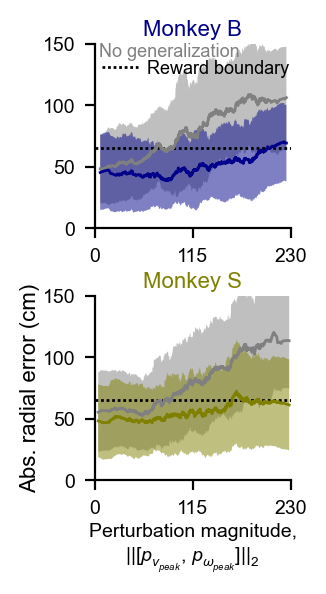

In [31]:
width = 1.5
height = 2.8
title_pad = 3
scatter_size = 0.6
scatter_lw = 0.4

xticks = [0, 115, 230]; yticks = np.arange(0, 151, 50)
titles = ['Monkey B', 'Monkey S']
colors = [monkB_c, monkS_c]
colors_ = ['gray', 'crimson']

with initiate_plot(width, height, 200) as fig:
    for idx, fig_idx in enumerate(range(1, 3)):
        ax = fig.add_subplot(2, 1, fig_idx)
        ax.set_title(titles[idx], fontsize=fontsize + 1, pad=title_pad, c=colors[idx])
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        plt.xticks(xticks, fontsize=fontsize)
        plt.yticks(yticks, fontsize=fontsize)
        ax.set_xlabel('', fontsize=fontsize)
        ax.set_ylabel('', fontsize=fontsize)
        ax.set_xlim([xticks[0], xticks[-1]]); ax.set_ylim([yticks[0], yticks[-1]])
        
        line = ax.plot(np.linspace(*ax.get_xlim()), 
                       np.linspace(*([arg.goal_radius_range[0] * arg.LINEAR_SCALE] * 2)), 
                       c='k', lw=lw, ls=(0, (1, 1)), label='Reward boundary')
        for d_idx, c in zip(range(idx * 2, idx * 2 + 2), ['gray', colors[idx]]):   # [0, 1], [2, 3]
            ax.plot(xdata_sorted[d_idx], ydata_mean[d_idx], c=c, lw=lw)
            ax.fill_between(xdata_sorted[d_idx], ydata_mean[d_idx] - ydata_std[d_idx], 
                            ydata_mean[d_idx] + ydata_std[d_idx],
                            edgecolor='None', facecolor=c, alpha=0.5)
        if fig_idx == 2:
            ax.set_xlabel('Perturbation magnitude,\n||[$p_{v_{peak}}$, $p_{\omega_{peak}}$]||$_{2}$', 
                          fontsize=fontsize)
            ax.set_ylabel(r'Abs. radial error (cm)', fontsize=fontsize + 1)
            ax.yaxis.set_label_coords(-0.28, 0.5)
            ax.xaxis.set_label_coords(0.5, -0.23)
            
        elif fig_idx == 1:
            ax.text(5, 140, 'No generalization', fontsize=fontsize - 0.5, c='gray')
            ax.legend(loc=[0, 0.78], frameon=False, 
                      fontsize=fontsize - 0.5, labelspacing=0.2,
                      ncol=1, columnspacing=0.1, handletextpad=0.5)
        
    plt.tight_layout(pad=0.05, h_pad=0.2)
        
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #            name='radial_error_monk'), orientation='portrait', format='pdf', transparent=True)

## 6d

In [32]:
subject_names = ['holistic', 'moho', 'homo', 'modular']
xdata = [np.hstack([np.linalg.norm(df[['perturb_vpeak', 'perturb_wpeak']], axis=1) 
                    for df in eval(f'{arg2}_perturbation_trajectories')])
         for arg1, arg2 in cartesian_prod(['sim_', ''], subject_names)]
ydata_a = [np.hstack([df[f'{arg1}relative_radius_end'].values
                      for df in eval(f'{arg2}_perturbation_trajectories')])
           for arg1, arg2 in cartesian_prod(['sim_', ''], subject_names)]

In [33]:
smoothing_window = 800
x_sorted_idx = [np.argsort(data) for data in xdata]
xdata_sorted = [data[idx] for idx, data in zip(x_sorted_idx, xdata)]
ydata_sorted = [data[idx] for idx, data in zip(x_sorted_idx, ydata_a)]
ydata_mean = [pd.Series(data).rolling(smoothing_window, center=True, min_periods=1).mean().values 
              for data in ydata_sorted]
ydata_std = [pd.Series(data).rolling(smoothing_window, center=True, min_periods=1).std().values 
             for data in ydata_sorted]

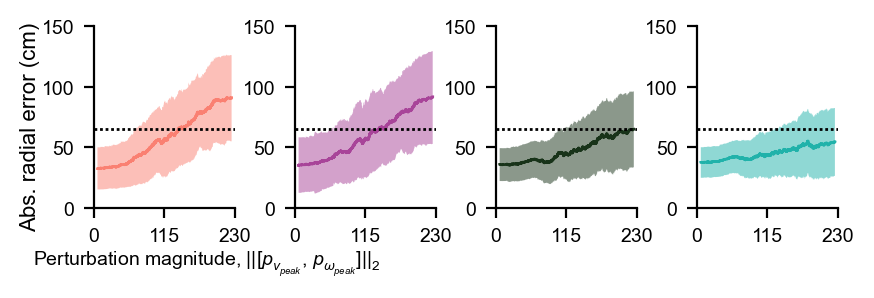

In [34]:
width = 4.2
height = 1.35
scatter_size = 0.6
scatter_lw = 0.4

xticks = [0, 115, 230]; yticks = np.arange(0, 151, 50)
colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]
colors_ = ['gray', 'crimson']

with initiate_plot(width, height, 200) as fig:
    for idx, fig_idx in enumerate(range(1, 5)):
        ax = fig.add_subplot(1, 4, fig_idx)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        plt.xticks(xticks, fontsize=fontsize)
        plt.yticks(yticks, fontsize=fontsize)
        ax.set_xlabel('', fontsize=fontsize)
        ax.set_ylabel('', fontsize=fontsize)
        ax.set_xlim([xticks[0], xticks[-1]]); ax.set_ylim([yticks[0], yticks[-1]])
        
        ax.plot(xdata_sorted[idx * 2 + 1], ydata_mean[idx * 2 + 1], c=colors[idx], lw=lw)
        ax.fill_between(xdata_sorted[idx * 2 + 1], ydata_mean[idx * 2 + 1] - ydata_std[idx * 2 + 1], 
                        ydata_mean[idx * 2 + 1] + ydata_std[idx * 2 + 1],
                        edgecolor='None', facecolor=colors[idx], alpha=0.5)
        
        line = ax.plot(np.linspace(*ax.get_xlim()), 
                       np.linspace(*([arg.goal_radius_range[0] * arg.LINEAR_SCALE] * 2)), 
                       c='k', lw=lw, ls=(0, (1, 1)))
        
        if fig_idx == 1:
            ax.set_xlabel('Perturbation magnitude, ||[$p_{v_{peak}}$, $p_{\omega_{peak}}$]||$_{2}$', 
                          fontsize=fontsize)
            ax.set_ylabel(r'Abs. radial error (cm)', fontsize=fontsize + 1)
            ax.xaxis.set_label_coords(0.8, -0.22)
            ax.yaxis.set_label_coords(-0.38, 0.45)
        
    plt.tight_layout(pad=0.1, w_pad=-0.3, rect=[0.004, 0, 1.004, 1])
        
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #            name='radial_error'), orientation='portrait', format='pdf', transparent=True)

## 6e

In [35]:
dfs = [holistic_perturbation_trajectories, moho_perturbation_trajectories,
       homo_perturbation_trajectories, modular_perturbation_trajectories]

In [36]:
max_reward_boundary = int(max([df.relative_radius_end.max() for dfs_ in dfs for df in dfs_])) + 1
hypo_reward_boundaries = np.arange(max_reward_boundary)

df = modular_perturbation_trajectories[0]
mask = np.linalg.norm(df[['perturb_vpeak', 'perturb_wpeak']], axis=1) > 115
targets = df[['target_x', 'target_y']].values[mask]
shuffled_targets = targets.copy()
rng = default_rng(1); rng.shuffle(shuffled_targets, axis=0)

ydata_perturb_agent = []; xdata_perturb_agent = []
for dfs_ in dfs:
    ydata_perturb = []; xdata_perturb = []
    for df_ in dfs_:
        df = df_[mask]
        ydata = []; xdata = []
        for reward_boundary in hypo_reward_boundaries:
            ydata.append((np.linalg.norm(np.vstack([[i[-1] for i in df.pos_x], [i[-1] for i in df.pos_y]]).T 
                                         - targets, axis=1) 
                          < reward_boundary).sum() / len(df))
            xdata.append((np.linalg.norm(np.vstack([[i[-1] for i in df.pos_x], [i[-1] for i in df.pos_y]]).T
                                         - shuffled_targets, axis=1) 
                          < reward_boundary).sum() / len(df))
        ydata_perturb.append(ydata); xdata_perturb.append(xdata)       
    ydata_perturb_agent.append(ydata_perturb)
    xdata_perturb_agent.append(xdata_perturb)

In [37]:
auc_data = [[np.trapz(ydata_perturb_agent[agent_idx][idx], xdata_perturb_agent[agent_idx][idx])
             for idx in range(8)] for agent_idx in range(4)]

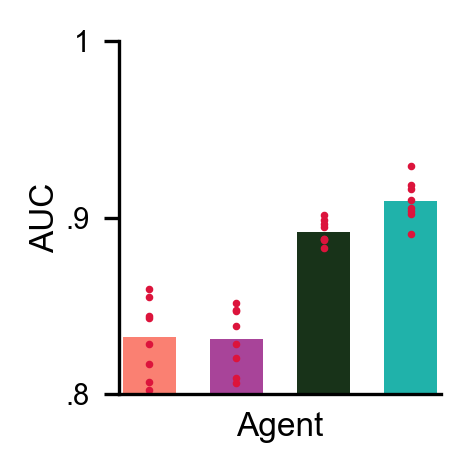

In [38]:
width = 1.4; height = 1.4
marker = '.'; marker_size = 5; marker_lw = lw * 0.7

yticks = np.around(np.linspace(0.8, 1, 3), 2)
colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]
xticks = np.arange(len(colors))

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks([], [], fontsize=fontsize - 1.3)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel('Agent', fontsize=fontsize + 1)
    ax.set_ylabel('AUC', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0] - 0.35, xticks[-1] + 0.35)
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.05)
    ax.yaxis.set_label_coords(-0.18, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    for agent_idx in range(len(colors)):
        ydata = auc_data[agent_idx]
        ymean = np.mean(ydata)
        yerror = sem(ydata)
        ax.bar(xticks[agent_idx], ymean, width=0.6, color=colors[agent_idx], alpha=1, zorder=0)
        ax.scatter([xticks[agent_idx]] * len(ydata), ydata, c='crimson', 
                   marker=marker, s=marker_size, lw=marker_lw, zorder=1)
    
    fig.tight_layout(pad=0.1, rect=(0, 0, 1, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='AUC'), orientation='portrait', format='pdf', transparent=True)

## S6a-b

In [39]:
def get_perturb_kernel(df, subject_name, seed_idx=0):
    assert subject_name in subject_names
    for trial_idx, trial in df.iterrows():
        if (trial.perturb_v == 0).all():
            continue

        for variable in variables:
            if 'sim' in variable:
                perturb_start_idx = trial.sim_perturb_start_idx
                data_size = trial.sim_action_v[perturb_start_idx:].size
            else:
                perturb_start_idx = np.where(trial.perturb_v != 0)[0][0]
                data_size = trial.action_v[perturb_start_idx:].size

            if 'v' in variable:
                sign = 'pos' if trial.perturb_vpeak > 0 else 'neg'
            else:
                sign = 'pos' if trial.perturb_wpeak > 0 else 'neg'

            eval(f'mean_{variable}')[f'{sign}_{subject_name}'][seed_idx, trial_idx, :data_size] = \
                                                                            trial[variable][perturb_start_idx:]

            if 'w' in variable:
                sign = 'cong' if (trial.target_theta - 90) * trial.perturb_wpeak > 0 else 'incong'
                if sign == 'cong':
                    if trial.perturb_wpeak > 0:
                        eval(f'mean_{variable}')[f'{sign}_{subject_name}'][seed_idx, trial_idx, :data_size] = \
                                                                            trial[variable][perturb_start_idx:]
                    else:
                        eval(f'mean_{variable}')[f'{sign}_{subject_name}'][seed_idx, trial_idx, :data_size] = \
                                                                            -trial[variable][perturb_start_idx:]
                if sign == 'incong':
                    if trial.perturb_wpeak < 0:
                        eval(f'mean_{variable}')[f'{sign}_{subject_name}'][seed_idx, trial_idx, :data_size] = \
                                                                            trial[variable][perturb_start_idx:]
                    else:
                        eval(f'mean_{variable}')[f'{sign}_{subject_name}'][seed_idx, trial_idx, :data_size] = \
                                                                            -trial[variable][perturb_start_idx:]

In [40]:
subject_names = ['bruno', 'schro', 'modular', 'holistic', 'moho', 'homo']
signs = ['pos', 'neg', 'cong', 'incong']
sign_names = ['_'.join(i) for i in cartesian_prod(signs, subject_names)]
dict_data = {}
for sign_name in sign_names:
    data_size = 6000 if 'bruno' in sign_name or 'schro' in sign_name else arg.EPISODE_LEN
    if 'bruno' in sign_name or 'schro' in sign_name:
        dict_data[sign_name] = np.zeros((1, len(bruno_perturbation_trajectory), data_size))
    else:
        dict_data[sign_name] = np.zeros((len(modular_perturbation_trajectories),
                                         len(modular_perturbation_trajectories[0]), data_size))
    
variables = ['_'.join(i) for i in cartesian_prod(['perturb', 'action'], ['v', 'w'])]
variables += ['sim_action_v', 'sim_action_w']
kernel_variables = {}
for variable in variables:
    kernel_variables[f'mean_{variable}'] = deepcopy(dict_data)
    if 'v' in variable:      
        [kernel_variables[f'mean_{variable}'].pop(key) for key in dict_data.keys() if 'cong' in key]
    
locals().update(kernel_variables)
for subject_name in subject_names:
    if subject_name in ['bruno', 'schro']:
        get_perturb_kernel(eval(f'{subject_name}_perturbation_trajectory'), subject_name)
    else:
        for seed_idx, df in enumerate(eval(f'{subject_name}_perturbation_trajectories')):
            get_perturb_kernel(df, subject_name, seed_idx=seed_idx)

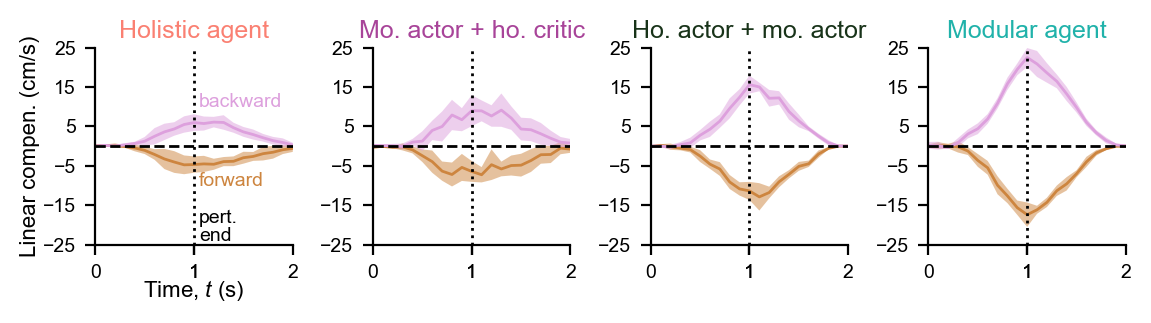

In [41]:
width = 5.6
height = 1.5
title_pad = 3.5

t_end = 2
x_ticks = np.linspace(0, t_end, 3)
x_ticks = np.insert(x_ticks, -1, 1)
y_ticks = np.arange(-25, 26, 10)

titles = ['Holistic agent', 'Mo. actor + ho. critic', 'Ho. actor + mo. actor', 'Modular agent']
subject_names = ['holistic', 'moho', 'homo', 'modular']
subject_colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]
data_sizes = [round(t_end / arg.DT) + 1] * 4
times = [np.linspace(0, t_end, data_size) for data_size in data_sizes]
gain_v = bruno_perturbation_trajectory.gain_v[0]

with initiate_plot(width, height, 200) as fig, warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for idx, fig_idx in enumerate(range(1, 5)):
        ax = fig.add_subplot(1, 4, fig_idx)
        ax.set_title(titles[idx], fontsize=fontsize + 2, pad=title_pad, c=subject_colors[idx])
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        plt.xticks(x_ticks, fontsize=fontsize)
        plt.yticks(y_ticks, fontsize=fontsize)
        ax.set_xlabel('', fontsize=fontsize)
        ax.set_ylabel('', fontsize=fontsize)
        ax.set_xlim([x_ticks[0], x_ticks[-1]]); ax.set_ylim([y_ticks[0], y_ticks[-1]])
        ax.xaxis.set_major_formatter(major_formatter)
        
        y1_ = mean_action_v[f'pos_{subject_names[idx]}'] - mean_sim_action_v[f'pos_{subject_names[idx]}']
        y1_mask = y1_.sum(axis=-1) == 0
        y1_mask = np.repeat(y1_mask[..., None], y1_.shape[-1], axis=-1)
        y1_[y1_mask] = np.nan
        y1_ = np.nanmean(y1_, axis=1)
        
        y1 = np.mean(y1_, axis=0)[:data_sizes[idx]] * gain_v
        err1 = np.std(y1_, axis=0)[:data_sizes[idx]] * gain_v
        l1 = ax.plot(times[idx], y1, c=pos_perturb_c, lw=lw, ls='-')
        ax.fill_between(times[idx], y1 - err1, y1 + err1,
                        edgecolor='None', facecolor=pos_perturb_c, alpha=0.5)
        
        y2_ = mean_action_v[f'neg_{subject_names[idx]}'] - mean_sim_action_v[f'neg_{subject_names[idx]}']
        y2_mask = y2_.sum(axis=-1) == 0
        y2_mask = np.repeat(y2_mask[..., None], y2_.shape[-1], axis=-1)
        y2_[y2_mask] = np.nan
        y2_ = np.nanmean(y2_, axis=1)
        
        y2 = np.nanmean(y2_, axis=0)[:data_sizes[idx]] * gain_v
        err2 = np.std(y2_, axis=0)[:data_sizes[idx]] * gain_v
        l2 = ax.plot(times[idx], y2, c=neg_perturb_c, lw=lw, ls='-')
        ax.fill_between(times[idx], y2 - err2, y2 + err2,
                        edgecolor='None', facecolor=neg_perturb_c, alpha=0.5)

        l6 = ax.plot(np.linspace(1, 1), np.linspace(*ax.get_ylim()), c='k', lw=lw, ls=':')
        l7 = ax.plot(*ax.get_xlim(), np.linspace(0, 0), c='k', lw=lw, ls='--')
    
        if fig_idx == 1:
            ax.text(1.05, -24, 'pert.\nend', fontsize=fontsize, linespacing=1)
            ax.text(1.05, -10, 'forward', fontsize=fontsize, c=pos_perturb_c)
            ax.text(1.05, 10, 'backward', fontsize=fontsize, c=neg_perturb_c)
            ax.set_xlabel('Time, $t$ (s)', fontsize=fontsize + 1)
            ax.set_ylabel('Linear compen. (cm/s)', fontsize=fontsize + 1)
            ax.xaxis.set_label_coords(0.5, -0.17)
            ax.yaxis.set_label_coords(-0.28, 0.5)  
        
    fig.tight_layout(pad=0.2, w_pad=0.8, rect=[-0, 0, 1, 1])
 
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #            name='sup_perturb_v_kernel'), orientation='portrait', format='pdf', transparent=True)

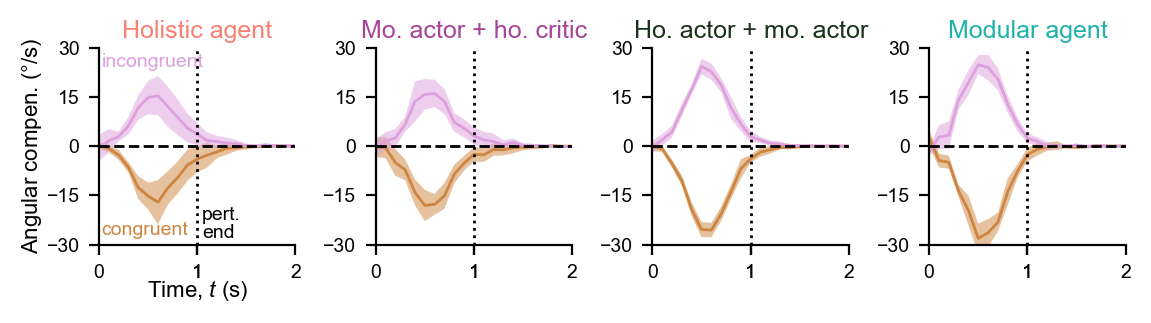

In [42]:
width = 5.6
height = 1.5
title_pad = 3.5

t_end = 2
x_ticks = np.linspace(0, t_end, 3)
x_ticks = np.insert(x_ticks, -1, 1)
y_ticks = [-30, -15, 0, 15, 30]

titles = ['Holistic agent', 'Mo. actor + ho. critic', 'Ho. actor + mo. actor', 'Modular agent']
subject_names = ['holistic', 'moho', 'homo', 'modular']
subject_colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]
data_sizes = [round(t_end / arg.DT) + 1] * 4
times = [np.linspace(0, t_end, data_size) for data_size in data_sizes]
gain_w = bruno_perturbation_trajectory.gain_w[0]

with initiate_plot(width, height, 200) as fig, warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for idx, fig_idx in enumerate(range(1, 5)):
        ax = fig.add_subplot(1, 4, fig_idx)
        ax.set_title(titles[idx], fontsize=fontsize + 2, pad=title_pad, c=subject_colors[idx])
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        plt.xticks(x_ticks, fontsize=fontsize)
        plt.yticks(y_ticks, fontsize=fontsize)
        ax.set_xlabel('', fontsize=fontsize)
        ax.set_ylabel('', fontsize=fontsize)
        ax.set_xlim([x_ticks[0], x_ticks[-1]]); ax.set_ylim([y_ticks[0], y_ticks[-1]])
        ax.xaxis.set_major_formatter(major_formatter)
        
        y1_ = mean_action_w[f'cong_{subject_names[idx]}'] - mean_sim_action_w[f'cong_{subject_names[idx]}']
        y1_mask = y1_.sum(axis=-1) == 0
        y1_mask = np.repeat(y1_mask[..., None], y1_.shape[-1], axis=-1)
        y1_[y1_mask] = np.nan
        y1_ = np.nanmean(y1_, axis=1)
        
        y1 = np.mean(y1_, axis=0)[:data_sizes[idx]] * gain_w
        err1 = np.std(y1_, axis=0)[:data_sizes[idx]] * gain_w
        l1 = ax.plot(times[idx], y1, c=pos_perturb_c, lw=lw, ls='-')
        ax.fill_between(times[idx], y1 - err1, y1 + err1,
                        edgecolor='None', facecolor=pos_perturb_c, alpha=0.5)
        
        
        y2_ = mean_action_w[f'incong_{subject_names[idx]}'] - mean_sim_action_w[f'incong_{subject_names[idx]}']
        y2_mask = y2_.sum(axis=-1) == 0
        y2_mask = np.repeat(y2_mask[..., None], y2_.shape[-1], axis=-1)
        y2_[y2_mask] = np.nan
        y2_ = np.nanmean(y2_, axis=1)
        
        y2 = np.nanmean(y2_, axis=0)[:data_sizes[idx]] * gain_w
        err2 = np.std(y2_, axis=0)[:data_sizes[idx]] * gain_w
        l2 = ax.plot(times[idx], y2, c=neg_perturb_c, lw=lw, ls='-')
        ax.fill_between(times[idx], y2 - err2, y2 + err2,
                        edgecolor='None', facecolor=neg_perturb_c, alpha=0.5)
            
        l6 = ax.plot(np.linspace(1, 1), np.linspace(*ax.get_ylim()), c='k', lw=lw, ls=':')
        l7 = ax.plot(*ax.get_xlim(), np.linspace(0, 0), c='k', lw=lw, ls='--')
    
        if fig_idx == 1:
            ax.text(1.05, -28, 'pert.\nend', fontsize=fontsize, linespacing=1)
            ax.text(0.02, -27, 'congruent', fontsize=fontsize, c=pos_perturb_c)
            ax.text(0.03, 24, 'incongruent', fontsize=fontsize, c=neg_perturb_c)
            ax.set_xlabel('Time, $t$ (s)', fontsize=fontsize + 1)
            ax.set_ylabel('Angular compen. ($\degree$/s)', fontsize=fontsize + 1)
            ax.xaxis.set_label_coords(0.5, -0.17)
            ax.yaxis.set_label_coords(-0.28, 0.5) 
        
    fig.tight_layout(pad=0.2, w_pad=0.8, rect=[-0, 0, 1, 1])
 
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #            name='sup_perturb_w_kernel'), orientation='portrait', format='pdf', transparent=True)